# Assignment 2 Model 1: Predicting Engagement from Steam Reviews

## 1. Predictive Task
**Goal**: Predict the number of hours a user has played a game (`hours`) based on their review text and available metadata.

**Why?** This task leverages both unstructured data (review text) and structured metadata (date, product counts) to understand engagement. Longer or more detailed reviews might correlate with higher playtime.

**Refinement**: The distribution of `hours` is highly skewed with extreme outliers. To address this, we will predict the logarithm of hours played (`log(hours + 1)`). This squashes the outliers and makes the target variable more normally distributed, which is better suited for linear regression models.

**Evaluation**:
- **Metrics**: We will use **Mean Squared Error (MSE)** and **Mean Absolute Error (MAE)** to evaluate the regression performance.
- **Baselines**: 
    1. **Global Average**: Predict the mean `log_hours` from the training set for all examples.
    2. **Linear Regression**: A standard linear model using TF-IDF features and metadata.
- **Validity**: We will assess validity by checking if our model outperforms the trivial baseline (Global Average) on a held-out test set.

## 2. Exploratory Analysis & Data Preparation

In [1]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.sparse import hstack
import re

# Configuration
DATA_FILE = 'steam_new.json'
# Using a subset for development if needed, but aiming for full dataset or large sample
#SAMPLE_SIZE = 200000 # Adjust based on memory constraints
SEED = 42

### Data Loading
We load the dataset from `steam_new.json`. The file is line-delimited JSON, but some lines use single quotes, so we must use `ast.literal_eval` for robust parsing.

In [2]:
data = []
with open(DATA_FILE, 'r') as f:
    for i, line in enumerate(f):
        # if i >= SAMPLE_SIZE:
        #     break
        try:
            data.append(ast.literal_eval(line))
        except (ValueError, SyntaxError):
            continue

df = pd.DataFrame(data)
print(f"Loaded {len(df)} rows.")
df.head()

Loaded 7793069 rows.


,username,hours,products,product_id,page_order,date,text,early_access,page,found_funny,compensation,user_id
0,Chaos Syren,0.1,41.0,725280,0,2017-12-17,This would not be acceptable as an entertainme...,False,1,NaN,NaN,NaN
1,₮ʜᴇ Wᴀʀᴛᴏɴ,51.1,769.0,328100,0,2017-12-27,looks like a facebook game,False,1,NaN,NaN,NaN
2,hello?<,14.6,2.0,328100,1,2017-10-16,Better than Minecraft,False,1,2.0,Product received for free,NaN
3,Cyderine916,5.0,64.0,35140,0,2018-01-04,I love and idolized Batman and this game is Ma...,False,1,NaN,NaN,NaN
4,DarklyThinking,16.6,577.0,35140,1,2018-01-04,Still worth playing in 2018.\nProbably my favo...,False,1,NaN,NaN,76561198007483075


### Data Cleaning & Preprocessing
1. **Missing Values**: `found_funny` has NaN values, which we assume means 0 votes. `compensation` also has high missingness but we might not use it.
2. **Date Parsing**: Convert `date` string to datetime objects to extract features like Month and Day of Week.
3. **Text Cleaning**: Lowercase and remove punctuation from reviews.

In [3]:
# 1. Fill NaN in found_funny
df['found_funny'] = df['found_funny'].fillna(0)

# 2. Date Parsing
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Drop rows with missing values in critical columns (hours, products, date)
df = df.dropna(subset=['hours', 'products', 'date'])

# Extract Date Features
df['review_month'] = df['date'].dt.month
df['review_dow'] = df['date'].dt.dayofweek

# 3. Text Cleaning
def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    return text

df['cleaned_text'] = df['text'].apply(clean_text)
df['review_length'] = df['cleaned_text'].apply(lambda x: len(x.split()))

print("Data cleaning complete.")
df[['text', 'cleaned_text', 'found_funny', 'date', 'review_length']].head()

Data cleaning complete.


,text,cleaned_text,found_funny,date,review_length
0,This would not be acceptable as an entertainme...,this would not be acceptable as an entertainme...,0.0,2017-12-17,38
1,looks like a facebook game,looks like a facebook game,0.0,2017-12-27,5
2,Better than Minecraft,better than minecraft,2.0,2017-10-16,3
3,I love and idolized Batman and this game is Ma...,i love and idolized batman and this game is ma...,0.0,2018-01-04,12
4,Still worth playing in 2018.\nProbably my favo...,still worth playing in 2018\nprobably my favor...,0.0,2018-01-04,48


### Data Splitting
We split the data into **Train (80%)**, **Validation (10%)**, and **Test (10%)**. The Test set will be held out until the final evaluation.

In [4]:
train_df, test_df = train_test_split(df, test_size=0.1, random_state=SEED)
train_df, val_df = train_test_split(train_df, test_size=0.1111, random_state=SEED) # 0.1111 of 90% is ~10%

print(f"Train size: {len(train_df)}")
print(f"Val size: {len(val_df)}")
print(f"Test size: {len(test_df)}")

Train size: 6201365
Val size: 775084
Test size: 775161


### Feature Engineering
We extract TF-IDF features from the review text and combine them with metadata features.
**Target Transformation**: We apply `log(x + 1)` to the `hours` variable to reduce the impact of outliers.

In [5]:
# Feature Engineering: TF-IDF
tfidf = TfidfVectorizer(max_features=1000, stop_words='english')
X_train_text = tfidf.fit_transform(train_df['cleaned_text'])
X_val_text = tfidf.transform(val_df['cleaned_text'])
X_test_text = tfidf.transform(test_df['cleaned_text'])

print(f"TF-IDF shape: {X_train_text.shape}")

# Prepare Feature Matrices
def get_meta_features(df):
    return df[['products', 'review_length', 'found_funny', 'review_month', 'review_dow']].values

X_train_meta = get_meta_features(train_df)
X_val_meta = get_meta_features(val_df)
X_test_meta = get_meta_features(test_df)

X_train = hstack([X_train_text, X_train_meta])
X_val = hstack([X_val_text, X_val_meta])
X_test = hstack([X_test_text, X_test_meta])

# Target Transformation: log(hours + 1)
y_train = np.log1p(train_df['hours'].values)
y_val = np.log1p(val_df['hours'].values)
y_test = np.log1p(test_df['hours'].values)

print(f"Final X_train shape: {X_train.shape}")

TF-IDF shape: (6201365, 1000)
Final X_train shape: (6201365, 1005)


## 3. Modeling
We compare a trivial baseline (Global Average) with a Ridge Regression model. Note that we are now predicting **log-hours**, as to avoid the skewness of the data.

In [6]:
# Baseline 1: Global Average (of log-hours)
global_mean = y_train.mean()
y_pred_baseline = np.full_like(y_val, global_mean)

mse_baseline = mean_squared_error(y_val, y_pred_baseline)
mae_baseline = mean_absolute_error(y_val, y_pred_baseline)

print(f"Baseline (Global Mean) - MSE: {mse_baseline:.4f}, MAE: {mae_baseline:.4f}")

Baseline (Global Mean) - MSE: 3.1335, MAE: 1.4365


In [7]:
# Model: Ridge Regression
model = Ridge(alpha=1.0)
model.fit(X_train, y_train)

y_pred_val = model.predict(X_val)

mse_model = mean_squared_error(y_val, y_pred_val)
mae_model = mean_absolute_error(y_val, y_pred_val)

print(f"Ridge Regression - MSE: {mse_model:.4f}, MAE: {mae_model:.4f}")

Ridge Regression - MSE: 2.6127, MAE: 1.2884


## 4. Evaluation & Analysis
We evaluate the models based on their ability to predict the log-transformed hours.

              Model       MSE       MAE
0    Global Average  3.133460  1.436536
1  Ridge Regression  2.612692  1.288403


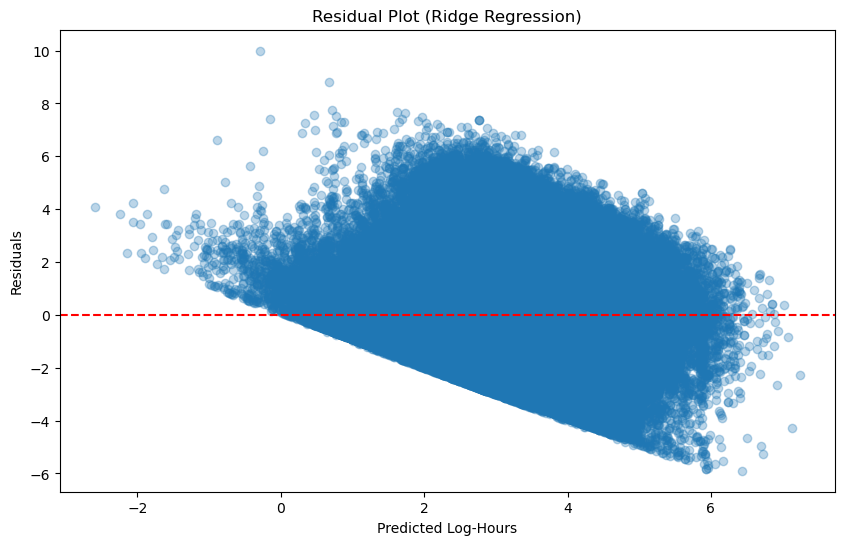

In [8]:
# Compare models
results = pd.DataFrame({
    'Model': ['Global Average', 'Ridge Regression'],
    'MSE': [mse_baseline, mse_model],
    'MAE': [mae_baseline, mae_model]
})
print(results)

# Plot Residuals
residuals = y_val - y_pred_val
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_val, residuals, alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Log-Hours')
plt.ylabel('Residuals')
plt.title('Residual Plot (Ridge Regression)')
plt.show()

## 5. Discussion of Related Work
Similar datasets (e.g., Amazon Reviews, Yelp) have been used extensively for sentiment analysis and helpfulness prediction. 
Prior work often uses more complex NLP models (like BERT) or recommender system approaches (Matrix Factorization) to model user-item interactions. 
Our approach is a simplified content-based regression, which serves as a strong baseline but lacks the collaborative filtering aspect of more advanced methods.